# Data split
Split data by day and machine:
- 50 mesurments for 1 day
- 6 days for 1 machine

In [1]:
import json
import pandas as pd
import numpy as np
from utils import import_df
from matplotlib import pyplot as plt
import math
from utils import export_df
from sklearn.decomposition import PCA

df = import_df("3-noise-generation-output.json")

In [2]:
def get_days(df):
    df["day"] = 0
    df["machine"] = 0
    counter_measure = 0
    counter_day = 0
    counter_machine = 0
    for i, row in df.iterrows():
        if (counter_measure % 50) == 0:
            counter_measure = 0
            counter_day += 1
        if (counter_day % 7) == 0:
            counter_measure = 0
            counter_day = 1
            counter_machine += 1
        df.at[i, "day"] = counter_day
        df.at[i, "machine"] = counter_machine
        counter_measure += 1
    return df


def get_labels(df):
    df["bearing"] = 0
    df.loc[df.label.isin(["bearings-1", "bearings-2"]), "bearing"] = 1

    df["magnet"] = 0
    df.loc[df.label == "magnet-partial", "magnet"] = 0.5
    df.loc[df.label == "magnet-1", "magnet"] = 0.7
    df.loc[df.label == "magnet-2", "magnet"] = 1

    df["electricity"] = 0
    df.loc[df.label == "magnet-2-nogrounding", "electricity"] = 1

    df["rotor"] = 0
    return df


df = get_days(df)
df = get_labels(df)
df_labels = df[["machine", "day", "bearing", "magnet", "electricity", "rotor"]]
df_labels = df_labels.groupby(["machine", "day"]).first()
df = df.drop("label", axis=1)
df_day = df.copy()

## Plot machine/day split

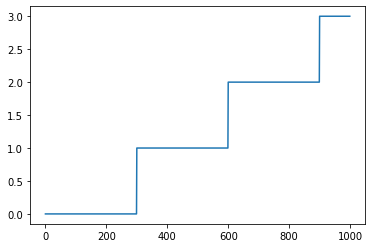

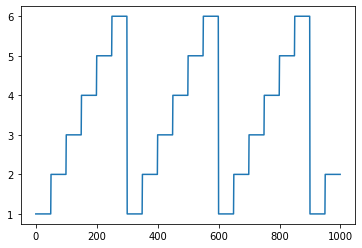

In [3]:
df.machine[:1000].plot()
plt.show()

df.day[:1000].plot()
plt.show()

## Extract features
- **Mean**: average
- **Variance**
- **Skewness**: normalised third central moment
- **RMS**: root mean square
- **Kurtosis**: normalised fourth central moment
- **Max**: maximum value
- **Interquantile Range**
- **Mean absolute deviation**
- **Normalised sixth central moment**
- **Trimmed mean**
- **PV**: peak value
- **Crest factor**

In [4]:
df = df_day.copy()
df = df.drop(["bearing", "magnet", "electricity", "rotor"], axis=1)
df_day_drop = df.copy()


def mean(df):
    df = df.mean()
    return df


df_gb = df.groupby(["machine", "day"])
df_mean = mean(df_gb)
df_mean.head()

s_00      s_01      s_02      s_03      s_04      s_05  \
machine day                                                               
0       1   -0.001947 -5.549816 -6.343277 -3.904963 -1.998774 -1.069093   
        2    0.167453 -5.678774 -7.037282 -4.230672 -2.211472 -0.920225   
        3    0.380043 -5.032054 -6.038568 -3.626030 -1.898269 -0.999874   
        4    0.198066 -5.081425 -6.535374 -3.857881 -1.831103 -0.993642   
        5    0.553147 -5.264652 -6.281117 -3.865195 -2.075699 -1.060344   

                 s_06      s_07      s_08      s_09  ...  vib_y_f2  vib_y_f3  \
machine day                                          ...                       
0       1   -0.877743 -0.094395 -0.089302 -0.149012  ...  1.216706  0.873888   
        2   -1.089935 -0.001527 -0.105820 -0.017330  ...  1.129328  1.026325   
        3   -1.087981 -0.028880 -0.202542  0.252725  ...  1.179571  0.882143   
        4   -1.106345  0.051811  0.006952 -0.015457  ...  1.340022  1.276172   
        5   -0.915790 -0.098523 -0.050948 -0.097805  ...  1.356382  1.181825   

             vib_y_kurt  vib_y_peak  vib_y_vel  vib_z_acc  vib_z_kurt  \
machine day                                                             
0       1      0.546348    0.748261   2.796025   1.640198    0.311309   
        2      0.553859    0.789363   2.855415   1.664345    0.292089   
        3      0.478678    0.780238   2.909234   1.787322    0.322310   
        4      0.485187    0.749857   2.991781   1.728405    0.307865   
        5      0.485330    0.739777   3.073236   1.727750    0.344296   

             vib_z_peak  vib_z_vel   current  
machine day                                   
0       1      0.596357   2.017347  3.956119  
        2      0.568815   2.069947  3.960495  
        3      0.614898   2.034595  3.958616  
        4      0.578728   2.133133  3.955396  
        5      0.584586   2.189938  3.956034  

[5 rows x 38 columns]

In [5]:
def variance(df):
    df = df.var()
    return df


df_var = variance(df_gb)
df_var.head()

s_00       s_01      s_02      s_03      s_04      s_05  \
machine day                                                                
0       1    1.209627   6.758132  4.735606  1.860695  0.725549  0.505775   
        2    1.917445  13.756866  4.248428  1.622321  1.033441  0.402006   
        3    1.930808  12.996280  3.002008  1.291401  0.961550  0.498631   
        4    1.911915   8.460012  5.112243  1.551762  1.273088  0.595168   
        5    1.270640  10.037377  4.576823  2.269287  0.695657  0.432776   

                 s_06      s_07      s_08      s_09  ...  vib_y_f2  vib_y_f3  \
machine day                                          ...                       
0       1    0.539717  0.255890  0.315309  0.441200  ...  0.878151  0.610482   
        2    0.512447  0.440945  0.309938  0.304498  ...  1.125950  0.717856   
        3    0.493588  0.381277  0.400252  0.269735  ...  1.039533  0.575384   
        4    0.407380  0.389424  0.343341  0.275475  ...  1.250342  0.640077   
        5    0.466897  0.339612  0.359530  0.412415  ...  1.128587  0.683207   

             vib_y_kurt  vib_y_peak  vib_y_vel  vib_z_acc  vib_z_kurt  \
machine day                                                             
0       1      0.036296    0.020720   0.406473   0.074704    0.036147   
        2      0.031648    0.028037   0.407091   0.075932    0.035155   
        3      0.032457    0.022978   0.275493   0.067568    0.049177   
        4      0.026496    0.019698   0.423552   0.060847    0.037583   
        5      0.028969    0.019429   0.441002   0.075534    0.047713   

             vib_z_peak  vib_z_vel   current  
machine day                                   
0       1      0.026586   0.440022  0.000251  
        2      0.038117   0.430938  0.000257  
        3      0.025943   0.367117  0.000181  
        4      0.037392   0.309794  0.000239  
        5      0.025400   0.332840  0.000238  

[5 rows x 38 columns]

In [6]:
def skewness(df):
    df = df.skew()
    return df


df_skew = skewness(df_gb)
df_skew.head()

s_00      s_01      s_02      s_03      s_04      s_05  \
machine day                                                               
0       1    0.017052  0.056699  0.270833 -0.241273  0.017218  0.307362   
        2    0.075068 -0.389362 -0.277796 -0.365515 -0.106898  0.499144   
        3   -0.051594  0.473401 -0.150379 -0.108289  0.150720  0.324522   
        4   -0.638678 -0.226163 -0.093471 -0.654258  0.068754 -0.183727   
        5   -0.172786 -0.394157  0.065519 -0.056673  0.128419 -0.039597   

                 s_06      s_07      s_08      s_09  ...  vib_y_f2  vib_y_f3  \
machine day                                          ...                       
0       1   -0.412560 -0.426777  0.437965 -0.144284  ...  0.392806 -0.071029   
        2    0.042149 -0.639389 -0.176182 -0.505195  ... -0.659586  0.216951   
        3    0.092670  0.069954  0.607159  0.128367  ...  0.110304  0.777686   
        4   -0.692403 -0.332391 -0.500842 -0.174213  ...  0.277024 -0.421684   
        5   -0.164100 -0.038627 -0.089376  0.324532  ...  0.149358  0.565384   

             vib_y_kurt  vib_y_peak  vib_y_vel  vib_z_acc  vib_z_kurt  \
machine day                                                             
0       1      0.128153    0.016601  -0.341629  -0.082865    0.050256   
        2     -0.213108    0.060900  -0.006261  -0.168779    0.144009   
        3      0.153457    0.030569  -0.195773   0.099272   -0.840763   
        4     -0.144670    0.006065  -0.151425  -0.217153    0.277414   
        5      0.409859    0.442876   0.439454   0.463341   -0.087789   

             vib_z_peak  vib_z_vel   current  
machine day                                   
0       1      0.170331   0.098139  0.036653  
        2      0.020598   0.298530 -0.446326  
        3      0.000635   0.073200  0.263288  
        4      0.147271  -0.177820  0.009636  
        5      0.164300   0.179988 -0.514505  

[5 rows x 38 columns]

In [7]:
def rms(df):
    """Not groupbyed"""
    df = df.copy()
    df = df ** 2
    # df = df[["day", "machine"]] ** 0.5
    df = df.groupby(["machine", "day"]).sum() / df.groupby(["machine", "day"]).count()
    df = np.sqrt(df)
    df = df.reset_index()
    df.machine = df.machine ** 0.5
    df.day = df.day ** 0.5
    df.machine = df.machine.astype("int")
    df.day = df.day.astype("int")
    df = df.set_index(["machine", "day"])
    return df


df_rms = rms(df_day_drop)
df_rms.head()

s_00      s_01      s_02      s_03      s_04      s_05  \
machine day                                                               
0       1    1.088778  6.117469  6.699109  4.131854  2.169363  1.280086   
        2    1.380991  6.762411  7.327127  4.414574  2.429687  1.113903   
        3    1.427103  6.169111  6.277441  3.796533  2.132075  1.220003   
        4    1.383079  5.840521  6.908047  4.050182  2.144893  1.253232   
        5    1.245471  6.128066  6.628553  4.142901  2.233891  1.244367   

                 s_06      s_07      s_08      s_09  ...  vib_y_f2  vib_y_f3  \
machine day                                          ...                       
0       1    1.139893  0.509590  0.563008  0.674226  ...  1.530020  1.167027   
        2    1.300060  0.657365  0.561193  0.546542  ...  1.542340  1.325459   
        3    1.291286  0.611952  0.658233  0.572897  ...  1.552459  1.158470   
        4    1.274061  0.619935  0.580106  0.519812  ...  1.738100  1.501962   
        5    1.138521  0.585258  0.595764  0.643220  ...  1.716329  1.437447   

             vib_y_kurt  vib_y_peak  vib_y_vel  vib_z_acc  vib_z_kurt  \
machine day                                                             
0       1      0.577984    0.761709   2.866374   1.662366    0.363783   
        2      0.581183    0.806580   2.924439   1.686552    0.346075   
        3      0.510824    0.794537   2.955271   1.805751    0.389971   
        4      0.511246    0.762620   3.060365   1.745570    0.362783   
        5      0.513746    0.752536   3.142764   1.749041    0.406570   

             vib_z_peak  vib_z_vel   current  
machine day                                   
0       1      0.617816   2.121535  3.956151  
        2      0.600753   2.169562  3.960526  
        3      0.635236   2.121167  3.958638  
        4      0.609566   2.203146  3.955426  
        5      0.605502   2.263186  3.956064  

[5 rows x 38 columns]

In [8]:
def kurtosis(df):
    df = df.apply(pd.DataFrame.kurt)
    df = df.drop(["machine", "day"], axis=1)
    return df


df_kurt = kurtosis(df_gb)
df_kurt.head()

s_00      s_01      s_02      s_03      s_04      s_05  \
machine day                                                               
0       1   -0.783070 -0.702866 -0.229414 -0.452642  0.177362  0.140611   
        2   -0.436758 -0.198389 -0.694583 -0.366405 -0.484234 -0.082793   
        3   -0.150476 -0.014693 -0.701602  0.221039 -0.510230  0.005174   
        4    0.266617  0.346863  0.122436  0.627583 -0.743611  0.148695   
        5   -0.594396  0.430753  1.239423 -0.719379 -0.193766 -0.402132   

                 s_06      s_07      s_08      s_09  ...  vib_y_f2  vib_y_f3  \
machine day                                          ...                       
0       1    0.416926 -0.702207 -0.011274  0.041781  ... -0.834549 -0.064481   
        2   -0.162346 -0.373736 -0.245948  0.828934  ...  1.078973 -0.856087   
        3   -0.063479 -0.767165 -0.069121 -0.582358  ... -0.633302 -0.201900   
        4    0.904375 -0.290969  0.389037 -0.412503  ... -0.124159  1.062977   
        5   -0.132470  0.046455  0.541211  0.413287  ... -0.104339  1.456011   

             vib_y_kurt  vib_y_peak  vib_y_vel  vib_z_acc  vib_z_kurt  \
machine day                                                             
0       1      0.447373   -0.111596  -0.389116  -0.780033   -0.959144   
        2     -0.044310   -0.203276  -0.925086  -0.322188   -1.048953   
        3     -0.433047   -0.261139  -0.462450   1.740743    3.620429   
        4     -0.399807   -0.689253  -0.264334  -0.337839   -0.354596   
        5     -0.421080   -0.472573   1.063227   0.953866   -0.299127   

             vib_z_peak  vib_z_vel   current  
machine day                                   
0       1     -0.935480   0.866390 -0.544231  
        2     -0.114338  -0.010363  0.093686  
        3     -0.666336   0.924304 -0.156938  
        4     -0.273951  -0.869243 -0.214377  
        5     -0.202214  -0.295519 -0.514613  

[5 rows x 38 columns]

In [9]:
def max_value(df):
    df_max = df.max()
    return df_max


df_max = max_value(df_gb)
df_max.head()

s_00      s_01      s_02      s_03      s_04      s_05  \
machine day                                                               
0       1    2.092136 -0.469683 -0.846743 -1.413258 -0.066998  0.646675   
        2    3.298956  1.321175 -3.174595 -2.070188  0.127047  0.832319   
        3    3.919768  4.859053 -2.194592 -0.788408  0.148038  0.794207   
        4    3.078245  1.023023 -0.933771 -1.808274  0.585468  0.991215   
        5    2.825097  0.596610 -0.533242 -1.065049 -0.351152  0.352453   

                 s_06      s_07      s_08      s_09  ...  vib_y_f2  vib_y_f3  \
machine day                                          ...                       
0       1    0.578685  0.713872  1.284865  1.275557  ...  3.347201  2.682579   
        2    0.654141  1.114292  0.995400  1.043266  ...  3.168289  2.874415   
        3    0.682092  1.272333  1.236027  1.175584  ...  3.406255  2.648595   
        4   -0.094035  1.334214  1.154978  0.915057  ...  4.183247  2.892129   
        5    0.517083  1.143767  1.275224  1.745950  ...  3.767780  3.974492   

             vib_y_kurt  vib_y_peak  vib_y_vel  vib_z_acc  vib_z_kurt  \
machine day                                                             
0       1      1.049357    1.108296   3.814487   2.249470    0.651933   
        2      0.917172    1.143809   4.183546   2.230011    0.634997   
        3      0.871058    1.137299   4.018554   2.648684    0.859042   
        4      0.813308    1.092779   4.463350   2.159220    0.744642   
        5      0.870522    1.060849   4.921094   2.574014    0.775904   

             vib_z_peak  vib_z_vel   current  
machine day                                   
0       1      0.936631   3.861766  3.990091  
        2      1.040886   3.835017  3.987346  
        3      0.950569   3.820558  3.989360  
        4      1.071956   3.265896  3.995067  
        5      0.928755   3.636325  3.981880  

[5 rows x 38 columns]

In [10]:
def interquantile_range(df):
    df_low = df.quantile(0.25)
    df_high = df.quantile(0.75)
    return df_low - df_high


df_quant = interquantile_range(df_gb)
df_quant.head()

s_00      s_01      s_02      s_03      s_04      s_05  \
machine day                                                               
0       1   -1.646086 -3.798444 -2.752559 -1.990221 -1.073105 -0.839090   
        2   -2.056332 -4.500720 -2.455808 -1.792605 -1.444887 -0.870080   
        3   -2.064367 -4.777301 -2.644293 -1.588820 -1.120192 -0.897608   
        4   -1.764328 -3.058191 -2.832153 -1.658859 -1.860634 -0.982622   
        5   -1.755062 -3.608520 -1.824668 -2.119254 -1.069760 -0.821441   

                 s_06      s_07      s_08      s_09  ...  vib_y_f2  vib_y_f3  \
machine day                                          ...                       
0       1   -0.774350 -0.836588 -0.750120 -0.857965  ... -1.555701 -0.968249   
        2   -0.977766 -0.909867 -0.722922 -0.510139  ... -1.258441 -1.346027   
        3   -0.977917 -0.863539 -0.702133 -0.757962  ... -1.409113 -0.878027   
        4   -0.865693 -0.894924 -0.670301 -0.674652  ... -1.399610 -0.983793   
        5   -0.848708 -0.729719 -0.680248 -0.771366  ... -1.095227 -0.969998   

             vib_y_kurt  vib_y_peak  vib_y_vel  vib_z_acc  vib_z_kurt  \
machine day                                                             
0       1     -0.223042   -0.190560  -0.729070  -0.417961   -0.299562   
        2     -0.246191   -0.214463  -1.134113  -0.362599   -0.308789   
        3     -0.246147   -0.174168  -0.746746  -0.293918   -0.295914   
        4     -0.225400   -0.223519  -0.940489  -0.341455   -0.284249   
        5     -0.238186   -0.206569  -0.706382  -0.310564   -0.274179   

             vib_z_peak  vib_z_vel   current  
machine day                                   
0       1     -0.280168  -0.800624 -0.023958  
        2     -0.241491  -0.873941 -0.018100  
        3     -0.226689  -0.844707 -0.018863  
        4     -0.233808  -0.859782 -0.022657  
        5     -0.195569  -0.780952 -0.022662  

[5 rows x 38 columns]

In [11]:
def mean_absolute_deviation(df):
    df = df.apply(pd.DataFrame.mad)
    df = df.drop(["machine", "day"], axis=1)
    return df


df_mad = mean_absolute_deviation(df_gb)
df_mad.head()

s_00      s_01      s_02      s_03      s_04      s_05  \
machine day                                                               
0       1    0.928010  2.132157  1.746514  1.121400  0.656738  0.548125   
        2    1.109639  2.966371  1.690054  1.047815  0.834436  0.511470   
        3    1.125878  2.899146  1.449874  0.908059  0.783447  0.560455   
        4    1.083378  2.232541  1.731385  0.981552  0.941259  0.618816   
        5    0.909245  2.423439  1.507104  1.242846  0.672426  0.513667   

                 s_06      s_07      s_08      s_09  ...  vib_y_f2  vib_y_f3  \
machine day                                          ...                       
0       1    0.565484  0.427538  0.440123  0.510627  ...  0.802867  0.620798   
        2    0.576403  0.554109  0.437922  0.397509  ...  0.796805  0.738294   
        3    0.563561  0.501744  0.492943  0.421163  ...  0.838551  0.607337   
        4    0.503830  0.497966  0.462946  0.415203  ...  0.888462  0.620108   
        5    0.535368  0.448393  0.454529  0.492183  ...  0.823715  0.658949   

             vib_y_kurt  vib_y_peak  vib_y_vel  vib_z_acc  vib_z_kurt  \
machine day                                                             
0       1      0.144989    0.115822   0.506573   0.229510    0.157337   
        2      0.144210    0.128662   0.540544   0.218068    0.160050   
        3      0.148340    0.116913   0.437208   0.195089    0.162719   
        4      0.133095    0.116513   0.523778   0.200843    0.160919   
        5      0.142116    0.115110   0.498056   0.213785    0.175168   

             vib_z_peak  vib_z_vel   current  
machine day                                   
0       1      0.138907   0.506767  0.012850  
        2      0.154131   0.535002  0.012337  
        3      0.132984   0.460588  0.010542  
        4      0.156154   0.477912  0.012583  
        5      0.122823   0.453391  0.012760  

[5 rows x 38 columns]

In [12]:
def trimmed_mean(df):
    n = len(df)
    trim = 0.1
    df = df.mean()
    trim_index = int(n * trim)
    # df = df.iloc[trim_index:-trim_index]
    return df


df_trim = trimmed_mean(df_gb)
df_trim.head()

s_00      s_01      s_02      s_03      s_04      s_05  \
machine day                                                               
0       1   -0.001947 -5.549816 -6.343277 -3.904963 -1.998774 -1.069093   
        2    0.167453 -5.678774 -7.037282 -4.230672 -2.211472 -0.920225   
        3    0.380043 -5.032054 -6.038568 -3.626030 -1.898269 -0.999874   
        4    0.198066 -5.081425 -6.535374 -3.857881 -1.831103 -0.993642   
        5    0.553147 -5.264652 -6.281117 -3.865195 -2.075699 -1.060344   

                 s_06      s_07      s_08      s_09  ...  vib_y_f2  vib_y_f3  \
machine day                                          ...                       
0       1   -0.877743 -0.094395 -0.089302 -0.149012  ...  1.216706  0.873888   
        2   -1.089935 -0.001527 -0.105820 -0.017330  ...  1.129328  1.026325   
        3   -1.087981 -0.028880 -0.202542  0.252725  ...  1.179571  0.882143   
        4   -1.106345  0.051811  0.006952 -0.015457  ...  1.340022  1.276172   
        5   -0.915790 -0.098523 -0.050948 -0.097805  ...  1.356382  1.181825   

             vib_y_kurt  vib_y_peak  vib_y_vel  vib_z_acc  vib_z_kurt  \
machine day                                                             
0       1      0.546348    0.748261   2.796025   1.640198    0.311309   
        2      0.553859    0.789363   2.855415   1.664345    0.292089   
        3      0.478678    0.780238   2.909234   1.787322    0.322310   
        4      0.485187    0.749857   2.991781   1.728405    0.307865   
        5      0.485330    0.739777   3.073236   1.727750    0.344296   

             vib_z_peak  vib_z_vel   current  
machine day                                   
0       1      0.596357   2.017347  3.956119  
        2      0.568815   2.069947  3.960495  
        3      0.614898   2.034595  3.958616  
        4      0.578728   2.133133  3.955396  
        5      0.584586   2.189938  3.956034  

[5 rows x 38 columns]

In [13]:
def peak_value(df):
    df = df.abs()
    df = df.groupby(["machine", "day"])
    df = df.max()
    return df


df_peak = peak_value(df_day_drop)
df_peak.head()

s_00       s_01       s_02      s_03      s_04      s_05  \
machine day                                                                 
0       1    2.473830  10.585154   9.989233  7.228274  3.889701  2.651333   
        2    3.298956  15.471328  10.946289  7.446655  4.538451  1.952552   
        3    3.919768  11.331507   9.514078  6.683428  3.822312  2.359576   
        4    3.285747  12.981169  11.897096  7.465139  4.035007  2.840596   
        5    2.825097  14.140674  11.679260  6.836924  4.135545  2.292190   

                 s_06      s_07      s_08      s_09  ...  vib_y_f2  vib_y_f3  \
machine day                                          ...                       
0       1    3.010621  1.302660  1.284865  1.724465  ...  3.347201  2.682579   
        2    2.745441  1.614949  1.343286  1.601236  ...  3.168289  2.874415   
        3    2.694928  1.272333  1.530553  1.175584  ...  3.406255  2.648595   
        4    3.178197  1.470871  1.693783  1.173174  ...  4.183247  2.892129   
        5    2.446352  1.510452  1.788435  1.745950  ...  3.767780  3.974492   

             vib_y_kurt  vib_y_peak  vib_y_vel  vib_z_acc  vib_z_kurt  \
machine day                                                             
0       1      1.049357    1.108296   3.814487   2.249470    0.651933   
        2      0.917172    1.143809   4.183546   2.230011    0.634997   
        3      0.871058    1.137299   4.018554   2.648684    0.859042   
        4      0.813308    1.092779   4.463350   2.159220    0.744642   
        5      0.870522    1.060849   4.921094   2.574014    0.775904   

             vib_z_peak  vib_z_vel   current  
machine day                                   
0       1      0.936631   3.861766  3.990091  
        2      1.040886   3.835017  3.987346  
        3      0.950569   3.820558  3.989360  
        4      1.071956   3.265896  3.995067  
        5      0.928755   3.636325  3.981880  

[5 rows x 38 columns]

In [14]:
def crest_factor(df):
    df_peak = peak_value(df)
    df_rms = rms(df)
    df = df_peak / df_rms
    return df


df_crest = crest_factor(df_day_drop)
df_crest.head()

s_00      s_01      s_02      s_03      s_04      s_05  \
machine day                                                               
0       1    2.272116  1.730316  1.491129  1.749402  1.793016  2.071215   
        2    2.388832  2.287842  1.493940  1.686834  1.867916  1.752893   
        3    2.746660  1.836814  1.515598  1.760403  1.792767  1.934074   
        4    2.375676  2.222605  1.722208  1.843161  1.881216  2.266617   
        5    2.268295  2.307526  1.761962  1.650274  1.851274  1.842053   

                 s_06      s_07      s_08      s_09  ...  vib_y_f2  vib_y_f3  \
machine day                                          ...                       
0       1    2.641144  2.556289  2.282144  2.557696  ...  2.187684  2.298644   
        2    2.111781  2.456701  2.393627  2.929757  ...  2.054209  2.168618   
        3    2.087011  2.079137  2.325246  2.052001  ...  2.194103  2.286288   
        4    2.494541  2.372621  2.919785  2.256920  ...  2.406793  1.925567   
        5    2.148711  2.580833  3.001916  2.714390  ...  2.195255  2.764966   

             vib_y_kurt  vib_y_peak  vib_y_vel  vib_z_acc  vib_z_kurt  \
machine day                                                             
0       1      1.815547    1.455012   1.330771   1.353174    1.792093   
        2      1.578112    1.418098   1.430547   1.322231    1.834850   
        3      1.705203    1.431398   1.359792   1.466805    2.202838   
        4      1.590835    1.432928   1.458437   1.236971    2.052580   
        5      1.694460    1.409698   1.565849   1.471671    1.908414   

             vib_z_peak  vib_z_vel   current  
machine day                                   
0       1      1.516036   1.820269  1.008579  
        2      1.732635   1.767646  1.006772  
        3      1.496403   1.801158  1.007761  
        4      1.758558   1.482378  1.010022  
        5      1.533859   1.606728  1.006526  

[5 rows x 38 columns]

# Merge all features

From: `s_00, s_01, s_02`

To: `s_00_mean, s_00_rms, s_00_variance, ... , s_01_mean, s_01_rms, ...`

In [15]:
df_mean = df_mean.add_suffix("_mean")
df_var = df_var.add_suffix("_var")
df_skew = df_skew.add_suffix("_skew")
df_rms = df_rms.add_suffix("_rms")
df_kurt = df_kurt.add_suffix("kurt")
df_max = df_max.add_suffix("_max")
df_quant = df_quant.add_suffix("_quant")
df_mad = df_mad.add_suffix("_mad")
df_trim = df_trim.add_suffix("_trim")
df_peak = df_peak.add_suffix("_peak")
df_crest = df_crest.add_suffix("_crest")

df_merge = pd.concat(
    [
        df_mean,
        df_var,
        df_skew,
        df_rms,
        df_kurt,
        df_max,
        df_quant,
        df_mad,
        df_trim,
        df_peak,
        df_crest,
    ],
    axis=1,
)
df_merge.head()

s_00_mean  s_01_mean  s_02_mean  s_03_mean  s_04_mean  s_05_mean  \
machine day                                                                     
0       1    -0.001947  -5.549816  -6.343277  -3.904963  -1.998774  -1.069093   
        2     0.167453  -5.678774  -7.037282  -4.230672  -2.211472  -0.920225   
        3     0.380043  -5.032054  -6.038568  -3.626030  -1.898269  -0.999874   
        4     0.198066  -5.081425  -6.535374  -3.857881  -1.831103  -0.993642   
        5     0.553147  -5.264652  -6.281117  -3.865195  -2.075699  -1.060344   

             s_06_mean  s_07_mean  s_08_mean  s_09_mean  ...  vib_y_f2_crest  \
machine day                                              ...                   
0       1    -0.877743  -0.094395  -0.089302  -0.149012  ...        2.187684   
        2    -1.089935  -0.001527  -0.105820  -0.017330  ...        2.054209   
        3    -1.087981  -0.028880  -0.202542   0.252725  ...        2.194103   
        4    -1.106345   0.051811   0.006952  -0.015457  ...        2.406793   
        5    -0.915790  -0.098523  -0.050948  -0.097805  ...        2.195255   

             vib_y_f3_crest  vib_y_kurt_crest  vib_y_peak_crest  \
machine day                                                       
0       1          2.298644          1.815547          1.455012   
        2          2.168618          1.578112          1.418098   
        3          2.286288          1.705203          1.431398   
        4          1.925567          1.590835          1.432928   
        5          2.764966          1.694460          1.409698   

             vib_y_vel_crest  vib_z_acc_crest  vib_z_kurt_crest  \
machine day                                                       
0       1           1.330771         1.353174          1.792093   
        2           1.430547         1.322231          1.834850   
        3           1.359792         1.466805          2.202838   
        4           1.458437         1.236971          2.052580   
        5           1.565849         1.471671          1.908414   

             vib_z_peak_crest  vib_z_vel_crest  current_crest  
machine day                                                    
0       1            1.516036         1.820269       1.008579  
        2            1.732635         1.767646       1.006772  
        3            1.496403         1.801158       1.007761  
        4            1.758558         1.482378       1.010022  
        5            1.533859         1.606728       1.006526  

[5 rows x 418 columns]

# Merge features with k-means clustering ones
Merge features with previous notebook kmeans clustering that computed centroid distance (CD) and centroid labels

In [16]:
df_cd = import_df("5-kmeans-clustering-output.json")

df_cd = get_days(df_cd)
df_cd = df_cd.groupby(["machine", "day"]).first()
df_cd = df_cd.add_suffix("_cd")

df_all = df_merge.join(df_cd)
# Merge with labels: bearing, magnet, electricity, rotor
df_all = df_all.join(df_labels)

df_all.head()
df_all = df_all.reset_index()

export_df(df_all, "6-feature-extractor-output.json")
df_all.head()

,machine,day,s_00_mean,s_01_mean,s_02_mean,s_03_mean,s_04_mean,s_05_mean,s_06_mean,s_07_mean,...,vib_z_acc_cd,vib_z_kurt_cd,vib_z_peak_cd,vib_z_vel_cd,current_cd,kmeans_label_cd,bearing,magnet,electricity,rotor
0,0,1,-0.001947,-5.549816,-6.343277,-3.904963,-1.998774,-1.069093,-0.877743,-0.094395,...,1.440183,0.277093,0.462698,3.196192,3.963271,1,0,0.0,0,0
1,0,2,0.167453,-5.678774,-7.037282,-4.230672,-2.211472,-0.920225,-1.089935,-0.001527,...,1.362753,0.013217,0.630779,1.657707,3.933538,1,0,0.0,0,0
2,0,3,0.380043,-5.032054,-6.038568,-3.626030,-1.898269,-0.999874,-1.087981,-0.028880,...,1.893666,0.538087,0.772260,1.775864,3.936720,1,0,0.0,0,0
3,0,4,0.198066,-5.081425,-6.535374,-3.857881,-1.831103,-0.993642,-1.106345,0.051811,...,1.586002,0.107214,0.515229,1.670386,3.960426,1,0,0.0,0,0
4,0,5,0.553147,-5.264652,-6.281117,-3.865195,-2.075699,-1.060344,-0.915790,-0.098523,...,1.644742,0.231594,0.286890,1.229940,3.967005,1,0,0.0,0,0


# UMAP
Show feature using dimensionality reduction teqnique

In [17]:
reducer = PCA()
df_all = df_all.drop(["machine", "day"], axis=1)
out = reducer.fit_transform(df_all)

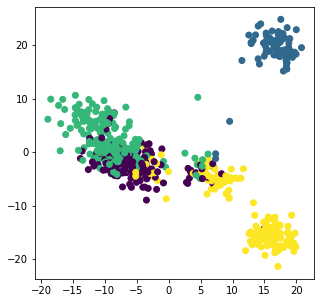

In [18]:
plt.figure(figsize=(5, 5))
plt.scatter(out[:, 0], out[:, 1], c=df_all.kmeans_label_cd)